In [43]:
import pandas as pd
import re
from collections import Counter
from operator import itemgetter
import os

In [44]:
def is_url_valid(url):
    if url[:4] != "http":
        return False
    return True
    

def domain_without_www(domain):
    if domain[:4] == "www.":
        return domain[4:]
    return domain


def filter_rows(df):
    df['is_valid'] = df.url.apply(is_url_valid)
    df = df[df['is_valid'] == True]
    df = df.drop(['is_valid'], axis=1)
    df['domain'] = df.domain.apply(domain_without_www)
    df = df.dropna()
    df = df.sort_values('visit_time_ms', ascending=False)
    return df.reset_index().drop('index', axis=1)


def fuck_of_this_domain(df, domains):
    for domain in domains:
        df = df.loc[df['domain'] != domain]
    return df.reset_index().drop('index', axis=1)
    

def clean_date(df):   
    df.day = [re.sub('[-:]', '/', df.day[i]) for i in range(len(df))]
    
    for i in range(len(df)):
        try:
            df.day[i] = pd.to_datetime(df.day[i] + '-'+ df.time[i])
        except ValueError:
            df.day[i] = None
    return filter_rows(df.drop('time', axis=1))


def find_indexes(df, url):
    return df.loc[df['url'] ==  url].index.tolist()


def replace_same_url(df, url, indexes):
    for index in range(len(indexes)):
        if df.url[index] == url:
            indexes.pop(index)
            last_i = indexes[-1] + 1
            while df.url[last_i] == url:
                last_i += 1
            indexes += [last_i]
    return indexes


def weighted_urls(df, url, previous_url, NUM_OF_NEXT=5, NUM_OF_PREVIOUS=2):
        
    indexes_after = [range(element - NUM_OF_NEXT, element) for element in find_indexes(df, url)]
    for match in indexes_after:
        match = replace_same_url(df, url, match)
    indexes_before = [range(element + 1, element + 1 + NUM_OF_PREVIOUS) for element in find_indexes(df, url)]


    weights = [float(1)/2**i for i in range(NUM_OF_NEXT)]
    urls_before = [df.url[i].values  for i in indexes_before]
    urls_after = [df.url[i].values  for i in indexes_after]
    urls_weighted = []
    
    for j in range(len(urls_after)):
        weights = [float(1)/2**(NUM_OF_NEXT - i -1) for i in range(NUM_OF_NEXT)]
        coef = 1
        i = 0
        while i < NUM_OF_PREVIOUS and previous_url[i] == urls_before[j][i]:
            weights = [weight*2 for weight in weights]
            i += 1
        urls_weighted.append([(urls_after[j][k], weights[k]) for k in range(len(weights))])            
    return urls_weighted


def get_weigths(df, url, previous_url):
    weigth_dic = {}
    for url_list in weighted_urls(df, url, previous_url):
        for url in url_list:
            if url[0] in weigth_dic:
                weigth_dic[url[0]] += url[1]
            else:
                weigth_dic[url[0]] = url[1]

    return sorted(weigth_dic.items(), key=itemgetter(1), reverse=True)


def is_in_time(df, index, threshold):
    if df.day[index-1] - df.day[index] < pd.Timedelta(threshold, 's') :
        return False
    else:
        return True

def to_int(number):
    if not isinstance(number, float) and "," in number:
        number = float(number.replace(",", "."))
    return number


def delta(df):
    df.visit_time_ms = df.visit_time_ms.apply(to_int)
    df = df.sort_values('visit_time_ms', ascending = False)
    df['delta'] = [float(df.visit_time_ms[index]) - float(df.visit_time_ms[index + 1]) for index in range(df.shape[0] - 1)] + [0]
    return df

In [47]:
def treat_data(df_path, filtered_domains):
    df = pd.read_csv(df_path, delimiter=";", header=None)
    df.columns = (['url', 'domain', 'root domain', 'visit_time_ms', 'visit_time_str', 'day of the week', 'transition_type', 'page title'])
    df = df[['url', 'domain', 'visit_time_ms', 'visit_time_str', 'transition_type']]
    df = filter_rows(df)
    df = fuck_of_this_domain(df, filtered_domains)
    df = delta(df)
    return df


def get_other_databases(folder_path, filtered_domains):
    df_list = []
    for df in os.listdir(folder_path):
        df_list.append(treat_data(folder_path + os.path.basename(df), filtered_domains))
    return df_list

In [48]:
filtered_domains = (['whatsapp.com','web.whatsapp.com', 'twitter.com', 'linkedin.com',
                     'google.co.il','fr-fr.messenger.com','youtube.com','facebook.com', 'localhost',
                     'plus.google.com','google.fr', 'mail.google.com', 'google.com','messenger.com',
                     'listenonrepeat.com', 'drive.google.com', 'docs.google.com', 'calendar.google.com',
                     'chrome.google.com', 'gmail.com', ])
df_path = 'databases/antho_secrets.csv'
folder_path = 'databases/other_databases/'
df = treat_data(df_path, filtered_domains)
df_list = get_other_databases(folder_path, filtered_domains)
for db in df_list:
    print db.shape

(6344, 6)
(3456, 6)
(11907, 6)
(1337, 6)
(3506, 6)
(992, 6)
(405, 6)


1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
1272
36.2806617228


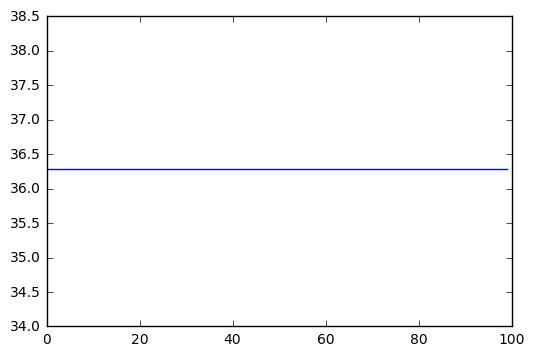

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

def percentage(sec_number):
    a = len(df[df['delta'] < 1000 * sec_num])
    print a
    b = len(df)
    c = float(a)/b*100
    return c

x_axis = range(100)
y_axis = [percentage(i) for i in x_axis]
plt.plot(x_axis, y_axis)

In [49]:
arg2, arg3 = 'http://www.lefigaro.fr/', [ "http://www.lefigaro.fr/",
       'http://www.lefigaro.fr/']
get_weigths(df, arg2, arg3)
for dataframe in df_list:
    for i in get_weigths(dataframe, arg2, arg3):
        print i
    print "---------------------------------------------------------------------------------------------------\n\n"
    print "---------------------------------------------------------------------------------------------------"

---------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------